**Mounting Drives**


In [107]:
#from google.colab import files, drive
#drive.mount('/content/drive', force_remount=True)
import os
import time
os.getcwd()
import matplotlib.pyplot as plt

**Data loading and Normalization**


In [126]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import math

# Import CVs to Dataframes
# weatherDF = pd.read_csv('/content/drive/My Drive/input/wx-frontier-agg.csv')
weatherDF = pd.read_csv('../data/wx/wx-frontier-agg-3.csv')
cropsDF = pd.read_csv('../data/agri/frontiers/Processed_Iowa+Cerro+Gordo_1960+2009_Annual+Crop.csv')

# Filtering and dataframe organization
cropsDF = cropsDF.sort_values(by='Year')
cropsDF['YEAR'] = cropsDF.Year
cropsDF.drop('Year', axis=1, inplace=True)
cropsDF.Value = cropsDF.Value.astype('float')

# Generating Corn Dataframe and Bean Data Frame
cornDF = cropsDF.loc[(cropsDF['Data Item'].str.contains('BU / ACRE')) & (cropsDF['Commodity'] == 'CORN')]
beansDF = cropsDF.loc[(cropsDF['Data Item'].str.contains('BU / ACRE')) & (cropsDF['Commodity'] == 'SOYBEANS')]

cornDF = cornDF[['YEAR', 'Value']]
beansDF = beansDF[['YEAR', 'Value']]

# Combining crop data with weather data
cropWeatherDF = weatherDF.merge(cornDF, on='YEAR')
cropWeatherDF['corn'] = cropWeatherDF.Value
cropWeatherDF.drop('Value', axis=1, inplace=True)
cropWeatherDF = cropWeatherDF.merge(beansDF, on='YEAR')
cropWeatherDF['beans'] = cropWeatherDF.Value
cropWeatherDF.drop('Value', axis=1, inplace=True)

# Normalizing Data
features = ['YEAR', 'GSP', 'GDD', 'GSTmax', 'GSTmin', 'frost', 'summer' ,'HWI', 'CWI', 'dry' ,'wet', 'PRCP95P']
ys = ['corn', 'beans']

def norm(x):
  return (x - x.mean()) / x.std()

for feat in features + ys:
  cropWeatherDF[feat] = norm(cropWeatherDF[feat])

cropWeatherDF = cropWeatherDF.sample(frac=1)

**Ridge Regression**

In [129]:
# Assigning X and y for corn and weather data
X = cropWeatherDF[features]
y = cropWeatherDF['corn']

# Generating list of Alphas
alph = [round((x+1) * 0.1, 1) for x in range(0, 100)]

# Ridge Regression on Corn and Weather
finalRMSE1 = 100
RMSEAlph1 = 0

finalR21 = -100
R2Alph1 = 0

alphplot = []
print("before")
for Alph in alph:
  ridge_Model = Ridge(alpha=Alph)
#  ridge_Model.fit(X, y)

  cornRMSE = 0
  N = 10
  for _ in range(N):
    cv = KFold(n_splits=5, shuffle=True)    
    cornRMSE += math.sqrt(-cross_val_score(ridge_Model, X, y, scoring="neg_mean_squared_error", cv=cv).mean())
  cornRMSE /= N
  alphplot.append((Alph, cornRMSE))
    
  # cornR2 = ridge_Model.score(X, y)
  cornR2 = cross_val_score(ridge_Model, X, y, scoring="r2", cv=5).mean()

  if finalRMSE1 > cornRMSE:
    finalRMSE1 = cornRMSE
    RMSEAlph1 = Alph
  
  if finalR21 < cornR2:
    finalR21 = cornR2
    R2Alph1 = Alph
print("after")

    
print("Lowest RMSE for Corn: {}".format(round(finalRMSE1, 2)))
print("Lowest RMSE found at Alpha: {}".format(round(RMSEAlph1, 2)))

print("Highest R2 for Corn: {}".format(round(finalR21, 2)))
print("Highest R2 found at Alpha: {}".format(round(R2Alph1, 2)))
print()

# Assigning X and y for bean and weather data
X = cropWeatherDF[features]
y = cropWeatherDF['beans']

# Ridge Regression on Beans and Weather
finalRMSE = 100
RMSEAlph = 0

finalR2 = -100
R2Alph = 0

for Alph in alph:
  ridge_Model = Ridge(alpha=Alph)
  ridge_Model.fit(X, y)
  
  N=10
  for _ in range(N):
    cv = KFold(n_splits=5, shuffle=True)
    beanRMSE += math.sqrt(-cross_val_score(ridge_Model, X, y, scoring="neg_mean_squared_error", cv=cv).mean())
  beanRMSE /= N
  # beanR2 = ridge_Model.score(X, y)
  beanR2 = cross_val_score(ridge_Model, X, y, scoring="r2", cv=5).mean()

  if finalRMSE > beanRMSE:
    finalRMSE = beanRMSE
    RMSEAlph = Alph
  
  if finalR2 < beanR2:
    finalR2 = beanR2
    R2Alph = Alph

print("Lowest RMSE for Beans: {}".format(round(finalRMSE, 2)))
print("Lowest RMSE found at Alpha: {}".format(round(RMSEAlph, 2)))

print("Highest R2 for Beans: {}".format(round(finalR2, 2)))
print("Highest R2 found at Alpha: {}\n\n".format(round(R2Alph, 2)))


print("****** FINAL STATS ******")

X = cropWeatherDF[features]
y = cropWeatherDF['corn']

N = 100
srmse = 0
sr2 = 0
ridge_Model = Ridge(alpha=RMSEAlph1)
for _ in range(N):
    cv = KFold(n_splits=5, shuffle=True)    
    srmse += math.sqrt(-cross_val_score(ridge_Model, X, y, scoring="neg_mean_squared_error", cv=cv).mean())
    sr2 += cross_val_score(ridge_Model, X, y, scoring="r2", cv=cv).mean()

rmse = srmse / N
r2 = sr2 / N
print('Final corn RMSE %f R2 %f' % (rmse, r2))

X = cropWeatherDF[features]
y = cropWeatherDF['beans']

N = 100
srmse = 0
sr2 = 0
ridge_Model = Ridge(alpha=RMSEAlph)
for _ in range(N):
    cv = KFold(n_splits=5, shuffle=True)    
    srmse += math.sqrt(-cross_val_score(ridge_Model, X, y, scoring="neg_mean_squared_error", cv=cv).mean())
    sr2 += cross_val_score(ridge_Model, X, y, scoring="r2", cv=cv).mean()

rmse = srmse / N
r2 = sr2 / N
print('Final corn RMSE %f R2 %f' % (rmse, r2))


X = cropWeatherDF[features]
y = cropWeatherDF['corn']
print("Alphas being used for Corn: {} {}".format(round(RMSEAlph1, 2), round(R2Alph1, 2)))
# Using lowest RMSE Alpha for Beans
ridge_Model = Ridge(alpha=RMSEAlph1)
ridge_Model.fit(X, y)
beanRMSEAlpha = -cross_val_score(ridge_Model, X, y, scoring="neg_mean_squared_error", cv=5).mean()
beanRMSEAlpha = math.sqrt(beanRMSEAlpha)
beanR2Alpha = cross_val_score(ridge_Model, X, y, scoring="r2", cv=5).mean()

print("Using the lowest Corn RMSE alpha: RMSE: {} R2:{}\n".format(round(beanRMSEAlpha, 2), round(beanR2Alpha, 2)))

# Using Highest R2 Alpha for Beans
ridge_Model = Ridge(alpha=R2Alph1)
ridge_Model.fit(X, y)
beanRMSEAlpha = -cross_val_score(ridge_Model, X, y, scoring="neg_mean_squared_error", cv=5).mean()
beanRMSEAlpha = math.sqrt(beanRMSEAlpha)
beanR2Alpha = cross_val_score(ridge_Model, X, y, scoring="r2", cv=5).mean()

print("Using the Highest Corn R2 alpha: RMSE: {} R2:{}\n".format(round(beanRMSEAlpha, 2), round(beanR2Alpha, 2)))

X = cropWeatherDF[features]
y = cropWeatherDF['beans']
print("Alphas being used: {} {}".format(round(RMSEAlph, 2), round(R2Alph, 2)))

# Using lowest RMSE Alpha for Beans
ridge_Model = Ridge(alpha=RMSEAlph)
ridge_Model.fit(X, y)
beanRMSEAlpha1 = -cross_val_score(ridge_Model, X, y, scoring="neg_mean_squared_error", cv=5).mean()
beanRMSEAlpha1 = math.sqrt(beanRMSEAlpha1)
beanR2Alpha1 = cross_val_score(ridge_Model, X, y, scoring="r2", cv=5).mean()

print("Using the lowest Bean RMSE alpha: RMSE: {} R2:{}\n".format(round(beanRMSEAlpha1, 2), round(beanR2Alpha1, 2)))

# Using Highest R2 Alpha for Beans
ridge_Model = Ridge(alpha=R2Alph)
ridge_Model.fit(X, y)
beanRMSEAlpha1 = -cross_val_score(ridge_Model, X, y, scoring="neg_mean_squared_error", cv=5).mean()
beanRMSEAlpha1 = math.sqrt(beanRMSEAlpha1)
beanR2Alpha1 = cross_val_score(ridge_Model, X, y, scoring="r2", cv=5).mean()

print("Using the Highest Bean R2 alpha: RMSE: {} R2:{}\n".format(round(beanRMSEAlpha1, 2), round(beanR2Alpha1, 2)))




before
after
Lowest RMSE for Corn: 0.37
Lowest RMSE found at Alpha: 2.7
Highest R2 for Corn: 0.81
Highest R2 found at Alpha: 1.5

Lowest RMSE for Beans: 0.44
Lowest RMSE found at Alpha: 3.3
Highest R2 for Beans: 0.8
Highest R2 found at Alpha: 2.7


****** FINAL STATS ******
Final corn RMSE 0.375902 R2 0.836921
Final corn RMSE 0.410268 R2 0.805755
Alphas being used for Corn: 2.7 1.5
Using the lowest Corn RMSE alpha: RMSE: 0.38 R2:0.81

Using the Highest Corn R2 alpha: RMSE: 0.38 R2:0.81

Alphas being used: 3.3 2.7
Using the lowest Bean RMSE alpha: RMSE: 0.41 R2:0.8

Using the Highest Bean R2 alpha: RMSE: 0.41 R2:0.8



Text(0.5, 1.0, 'Alpha vs error in Ridge Regression')

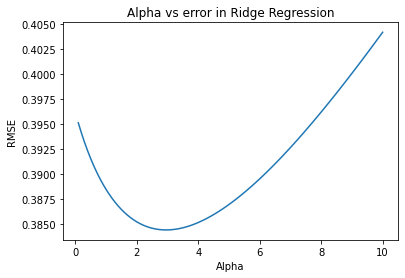

In [109]:
plt.plot([x[0] for x in alphplot], [x[1] for x in alphplot])
plt.gca().set_xlabel('Alpha')
plt.gca().set_ylabel('RMSE')
plt.gca().set_title('Alpha vs error in Ridge Regression')

**Random Forest**


In [131]:
from sklearn import tree
from sklearn import ensemble
param_grid = {
#    'bootstrap': [True],
#    'max_depth': [80, 90, 100, 110],
#    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators':  [400, 500, 600]
}

features = ['YEAR', 'GSP', 'GDD', 'GSTmax', 'GSTmin', 'frost', 'summer' ,'HWI', 'CWI', 'dry' ,'wet', 'PRCP95P']

# Assigning X and y for corn and weather data
r2 = 0
rmse = 0
N = 25

X = cropWeatherDF[features]
y = cropWeatherDF['corn']

###
### Commment this back in to re-train hyperparameters
###
#start = time.time()
#gs = GridSearchCV(RF_model, n_jobs=-1, param_grid = param_grid, scoring="neg_mean_squared_error")
#gs.fit(X, y)
#print('fit ', time.time() - start)

# this is what we got
RF_model = ensemble.RandomForestRegressor(n_estimators=400, min_samples_leaf=3)
print(RF_model)

N = 100
rmse = 0
r2 = 0
for _ in range(N):
    start = time.time()
    cv = KFold(n_splits=5, shuffle=True)
    rmse += math.sqrt(-cross_val_score(RF_model, X, y, scoring="neg_mean_squared_error", cv=cv).mean())
    r2 += cross_val_score(RF_model, X, y, scoring="r2", cv=cv).mean()
    print('pass time', time.time() - start)

rmse /= N
r2 /= N
print('RMSE %f r2 %f' % (rmse, r2))
print(RF_model)




RandomForestRegressor(min_samples_leaf=3, n_estimators=400)
pass time 4.058839797973633
pass time 4.097641229629517
pass time 3.9986815452575684
pass time 4.030722141265869
pass time 3.9868171215057373
pass time 4.00839376449585
pass time 3.9911322593688965
pass time 3.9838075637817383
pass time 4.033099889755249
pass time 3.99540376663208
pass time 4.0029261112213135
pass time 4.138638496398926
pass time 3.9931249618530273
pass time 3.9823217391967773
pass time 4.034988641738892
pass time 4.033292770385742
pass time 3.986722230911255
pass time 4.01923942565918
pass time 4.20987343788147
pass time 4.032468318939209
pass time 4.017915964126587
pass time 3.9809045791625977
pass time 3.9974420070648193
pass time 3.9757425785064697
pass time 3.9762136936187744
pass time 3.987283945083618
pass time 3.9665327072143555
pass time 3.981708288192749
pass time 4.001798152923584
pass time 4.004878044128418
pass time 4.021510362625122
pass time 3.9986422061920166
pass time 3.985260248184204
pass ti

In [136]:
##
## This goes in a separate cell b/c it takes soo long to run
##

param_grid = {
#    'bootstrap': [True],
#    'max_depth': [80, 90, 100, 110],
#    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators':  [400, 500, 600]
}

features = ['YEAR', 'GSP', 'GDD', 'GSTmax', 'GSTmin', 'frost', 'summer' ,'HWI', 'CWI', 'dry' ,'wet', 'PRCP95P']

# Assigning X and y for corn and weather data
r2 = 0
rmse = 0
N = 25

X = cropWeatherDF[features]
y = cropWeatherDF['beans']

###
### Commment this back in to re-train hyperparameters
###
start = time.time()
gs = GridSearchCV(RF_model, n_jobs=-1, param_grid = param_grid, scoring="neg_mean_squared_error")
gs.fit(X, y)
print('fit ', time.time() - start)

# this is what we got
RF_model = gs.best_estimator_  #ensemble.RandomForestRegressor(n_estimators=400, min_samples_leaf=3)
print(RF_model)

N = 100
rmse = 0
r2 = 0
for _ in range(N):
    start = time.time()
    cv = KFold(n_splits=5, shuffle=True)
    rmse += math.sqrt(-cross_val_score(RF_model, X, y, scoring="neg_mean_squared_error", cv=cv).mean())
    r2 += cross_val_score(RF_model, X, y, scoring="r2", cv=cv).mean()
    print('pass time', time.time() - start)

rmse /= N
r2 /= N
print('RMSE %f r2 %f' % (rmse, r2))
print(RF_model)


fit  26.415119409561157
RandomForestRegressor(min_samples_leaf=3, min_samples_split=4, n_estimators=400)
pass time 4.000509262084961
pass time 3.987582206726074
pass time 3.9771945476531982
pass time 3.9844019412994385
pass time 4.1321210861206055
pass time 4.019560813903809
pass time 3.9882402420043945
pass time 4.025741100311279
pass time 3.9723663330078125
pass time 3.9764230251312256
pass time 4.036841154098511
pass time 4.010440826416016
pass time 3.995866298675537
pass time 3.967555046081543
pass time 4.043347358703613
pass time 3.9762256145477295
pass time 3.9778504371643066
pass time 3.9793403148651123
pass time 3.980559825897217
pass time 3.989191770553589
pass time 3.9749536514282227
pass time 4.033349275588989
pass time 3.976083517074585
pass time 3.9739553928375244
pass time 3.9767284393310547
pass time 3.981448173522949
pass time 3.9771292209625244
pass time 3.971729278564453
pass time 3.9887309074401855
pass time 3.9728775024414062
pass time 4.03685450553894
pass time 4.0

In [134]:
print(gs.best_estimator_)
print(RF_model)
#math.sqrt(-cornFit.score(X,y))
r2

RandomForestRegressor(min_samples_leaf=3, n_estimators=400)
RandomForestRegressor(min_samples_leaf=3, n_estimators=400)


0.8574512804043083